## 3.16.2 获取和读取数据集

In [158]:
%matplotlib inline
import sys
sys.path.append("../")
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

In [174]:
# 获取训练集，测试集
train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv')

In [175]:
train_data.shape

(1460, 81)

In [176]:
test_data.shape

(1459, 80)

In [177]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [178]:
# id这一个特征没用，我们把它去除掉
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:, 1:]))

In [179]:
#all_features.dtypes[all_features.dtypes != 'object']

## 3.16.3 预处理数据

In [180]:
# 对连续数值的特征做标准化(standardization)：设该特征在整个数据集上的均值为μ
# 标准差为σ。那么我们可以将该特征值的每个值先减去μ，再处以σ得到标准化后的每个特征值。缺失的特征值，替换成均值

# 得到哪些是数字类型
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 让数字类型的特征，做标准化处理
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x - x.mean()) / (x.std()))

# 每个特征的均值变为0,所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features[numeric_features]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0.348780,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,-0.059772,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0.627338,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0.785188,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,1.685860,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,-2.195385,-0.740634,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.078492,-1.363335
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,-0.867591,-0.740634,-0.347564,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.815205,-1.363335
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0.478774,3.005615,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,-1.363335
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,-2.195385,-0.108355,-0.229178,-0.359539,-0.103313,-0.285886,-0.063139,1.144116,0.289865,-1.363335


In [181]:
# dummy_na = True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [182]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1,1))

## 3.16.4 训练模型

In [183]:
#平方损失函数
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

下面定义比赛用来评价模型的对数均方根误差。
$$
    \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i) - log(\hat{y}_i)^2}
$$

In [184]:
def log_rmse(net, features, labels):
    # 将小于1的值设成1,使得取对数时数值更稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [185]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_dacay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    
    # 这里使用了Adam算法
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_dacay})
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## 3.16.5 K折交叉验证

In [186]:
# 返回第i折交叉验证时所需要的训练和验证数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # 切片从 j * fold_size 到 (j+1) * fold_size，共fold_size个
        idx = slice(j * fold_size, (j + 1) * fold_size)
        
        
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
        return X_train, y_train, X_valid, y_valid

In [193]:
def k_fold(k, X_train, y_train, num_epochs, 
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data= get_k_fold_data(k, i , X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold {}, train rmse {}, valid rmse {}'.format(i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## 3.16.6模型选择
- 我们使用一组未经调优化的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差

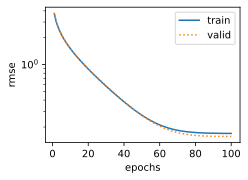

fold 0, train rmse 0.16947980225086212, valid rmse 0.15694518387317657
fold 1, train rmse 0.16209764778614044, valid rmse 0.18812106549739838
fold 2, train rmse 0.16367067396640778, valid rmse 0.16829364001750946
fold 3, train rmse 0.16783882677555084, valid rmse 0.1546812802553177
fold 4, train rmse 0.16235163807868958, valid rmse 0.18284402787685394


In [194]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
#print('{}-fold validation: avg train rmse {}, avg valid rmse {}'.format(k, train_l, valid_l))